In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:

# it's nice sometimes to exclude sex chromosomes and mito for analysis
autosomal_chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9',
 'chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17',
 'chr18','chr19','chr20','chr21','chr22']

In [4]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp
import pandas as pd

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


In [5]:
# from cooltools.expected import make_diag_tables#, _diagsum_symm
from cooltools.expected import diagsum, diagsum_asymm, blocksum_asymm
from cooltools import expected
from cooltools import numutils
# from cooltools.lib import assign_supports
from cooler.tools import split, partition
from functools import partial
from cooltools import eigdecomp

In [6]:
from cooltools.expected import make_diag_table
from cooltools.expected import _diagsum_symm

def make_diag_tables(clr, regions, regions2=None, weight_name="weight", bad_bins=None):
    """
    For every support region infer diagonals that intersect this region
    and calculate the size of these intersections in pixels, both "total" and
    "n_valid", where "n_valid" does not include "bad" bins into counting.

    "Bad" pixels are inferred from the balancing weight column `weight_name` or
    provided directly in the form of an array `bad_bins`.

    Setting `weight_name` and `bad_bins` to `None` yields 0 "bad" pixels per
    diagonal per support region.

    When `regions2` are provided, all intersecting diagonals are reported for
    each rectangular and asymmetric block defined by combinations of matching
    elements of `regions` and `regions2`.
    Otherwise only `regions`-based symmetric square blocks are considered.
    Only intra-chromosomal regions are supported.

    Parameters
    ----------
    clr : cooler.Cooler
        Input cooler
    regions : list
        a list of genomic support regions
    regions2 : list
        a list of genomic support regions for asymmetric regions
    weight_name : str
        name of the weight vector in the "bins" table,
        if weight_name is None returns 0 for each block.
        Balancing weight are used to infer bad bins.
    bad_bins : array-like
        a list of bins to ignore. Indexes of bins must
        be absolute, as in clr.bins()[:], as opposed to
        being offset by chromosome start.
        "bad_bins" will be combined with the bad bins
        masked by balancing if there are any.

    Returns
    -------
    diag_tables : dict
        dictionary with DataFrames of relevant diagonals for every support.
    """

    regions = bioframe.from_any(regions).values
    if regions2 is not None:
        regions2 = bioframe.from_any(regions2).values

    bins = clr.bins()[:]
    if weight_name is None:
        # ignore bad bins
        sizes = dict(bins.groupby("chrom").size())
        bad_bin_dict = {
            chrom: np.zeros(sizes[chrom], dtype=bool) for chrom in sizes.keys()
        }
    elif isinstance(weight_name, str):
        # using balacning weight to infer bad bins
        if weight_name not in clr.bins().columns:
            raise KeyError(f"Balancing weight {weight_name} not found!")
        groups = dict(iter(bins.groupby("chrom")[weight_name]))
        bad_bin_dict = {
            chrom: np.array(groups[chrom].isnull()) for chrom in groups.keys()
        }
    else:
        raise ValueError("`weight_name` can be `str` or `None`")

    # combine custom "bad_bins" with "bad_bin_dict":
    if bad_bins is not None:
        # check if "bad_bins" are legit:
        try:
            bad_bins_chrom = bins.iloc[bad_bins].reset_index(drop=False)
        except IndexError:
            raise ValueError("Provided `bad_bins` are incorrect or out-of-bound")
        # group them by observed chromosomes only
        bad_bins_grp = bad_bins_chrom[["index", "chrom"]].groupby(
            "chrom", observed=True
        )
        # update "bad_bin_dict" with "bad_bins" for each chrom:
        for chrom, bin_ids in bad_bins_grp["index"]:
            co = clr.offset(chrom)
            # adjust by chromosome offset
            bad_bin_dict[chrom][bin_ids.values - co] = True

    diag_tables = {}
    for i in range(len(regions)):
        chrom, start1, end1, name1 = regions[i]
        if regions2 is not None:
            chrom2, start2, end2, name2 = regions2[i]
            # cis-only for now:
            assert chrom2 == chrom
        else:
            start2, end2 = start1, end1

        # translate regions into relative bin id-s:
        lo1, hi1 = clr.extent((chrom, start1, end1))
        lo2, hi2 = clr.extent((chrom, start2, end2))
        co = clr.offset(chrom)
        lo1 -= co
        lo2 -= co
        hi1 -= co
        hi2 -= co

        bad_mask = bad_bin_dict[chrom]
        newname = name1
        if regions2 is not None:
            newname = (name1, name2)
        diag_tables[newname] = make_diag_table(bad_mask, [lo1, hi1], [lo2, hi2])

    return diag_tables
def diagsum(
    clr,
    regions,
    transforms={},
    weight_name="weight",
    bad_bins=None,
    chunksize=10000000,
    ignore_diags=2,
    map=map,
):
    """

    Intra-chromosomal diagonal summary statistics.

    Parameters
    ----------
    clr : cooler.Cooler
        Cooler object
    regions : sequence of genomic range tuples
        Support regions for intra-chromosomal diagonal summation
    transforms : dict of str -> callable, optional
        Transformations to apply to pixels. The result will be assigned to
        a temporary column with the name given by the key. Callables take
        one argument: the current chunk of the (annotated) pixel dataframe.
    weight_name : str
        name of the balancing weight vector used to count
        "bad"(masked) pixels per diagonal.
        Use `None` to avoid masking "bad" pixels.
    bad_bins : array-like
        a list of bins to ignore per support region.
        Combines with the list of bad bins from balacning
        weight.
    chunksize : int, optional
        Size of pixel table chunks to process
    ignore_diags : int, optional
        Number of intial diagonals to exclude from statistics
    map : callable, optional
        Map functor implementation.

    Returns
    -------
    Dataframe of diagonal statistics for all regions

    """
    spans = partition(0, len(clr.pixels()), chunksize)
    fields = ["count"] + list(transforms.keys())

    regions = bioframe.from_any(regions)

    dtables = make_diag_tables(clr, regions, weight_name=weight_name, bad_bins=bad_bins)

    # combine masking with existing transforms and add a "count" transform:
    if bad_bins is not None:
        # turn bad_bins into a mask of size clr.bins:
        mask_size = len(clr.bins())
        bad_bins_mask = np.ones(mask_size, dtype=int)
        bad_bins_mask[bad_bins] = 0
        #
        masked_transforms = {}
        bin1 = "bin1_id"
        bin2 = "bin2_id"
        for field in fields:
            if field in transforms:
                # combine masking and transform, minding the scope:
                t = transforms[field]
                masked_transforms[field] = (
                    lambda p, t=t, m=bad_bins_mask: t(p) * m[p[bin1]] * m[p[bin2]]
                )
            else:
                # presumably field == "count", mind the scope as well:
                masked_transforms[field] = (
                    lambda p, f=field, m=bad_bins_mask: p[f] * m[p[bin1]] * m[p[bin2]]
                )
        # substitute transforms to the masked_transforms:
        transforms = masked_transforms

    for dt in dtables.values():
        for field in fields:
            agg_name = "{}.sum".format(field)
            dt[agg_name] = 0

    job = partial(_diagsum_symm, clr, fields, transforms, regions.values)
    results = map(job, spans)
    for result in results:
        for i, agg in result.items():
            region = regions.loc[i, "name"]
            for field in fields:
                agg_name = "{}.sum".format(field)
                dtables[region][agg_name] = dtables[region][agg_name].add(
                    agg[field], fill_value=0
                )

    if ignore_diags:
        for dt in dtables.values():
            for field in fields:
                agg_name = "{}.sum".format(field)
                j = dt.columns.get_loc(agg_name)
                dt.iloc[:ignore_diags, j] = np.nan

    # returning dataframe for API consistency
    result = []
    for i, dtable in dtables.items():
        dtable = dtable.reset_index()
        dtable.insert(0, "region", i)
        result.append(dtable)
    return pd.concat(result).reset_index(drop=True)

In [7]:
balance = True
weight_name = "weight"
nproc = 2
chunksize = int(1e6)
contact_type = "cis"
ignore_diags = 2

weight1 = weight_name + "1"
weight2 = weight_name + "2"
transforms = {"balanced": lambda p: p["count"] * p[weight1] * p[weight2]}


In [8]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.make_viewframe(hg19_arms)
# # hg19_arms.to_csv("hg19_arms.bed",sep="\t",index=False,header=False)

In [9]:
# ins_samples = {
#     "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
# }

ins_samples = {
    #cooler locations, some expected at these locations
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.mcool",

    #polII degron
    "PolII-NT.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.mcool",
    "PolII-IAA.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.mcool",

    #AAVS1 clone
    "mutControl-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-IAA-pool.mcool",

    #DDX55 clones
    "mutDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-IAA.hg19.mapq_30.1000.mcool",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",

    #siCONTROL
    "siControl-NT.hg19" : "/data/alv/CTCF_degron/data/siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19" : "/data/alv/CTCF_degron/data/siCTRL-IAA.hg19.mapq_30.1000.mcool",

    #siDDX55
    "siDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/siDDX55-IAA.hg19.mapq_30.1000.mcool",

    #siTAF5L
    "siTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-IAA.hg19.mapq_30.1000.mcool",

    #RAD21 degron
    "RAD21-NT.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-NT.hg19.mapq_30.1000.mcool",
    "RAD21-IAA.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",

    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-PlaB-hg19-combined-90000000.mcool",

    #compare with WT
    "Ctrl500M-wtHAP1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-noTIR1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-CT442-NT.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-IAA-pool-500000000.mcool",
}

In [10]:
ev1_samples = {
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-NT-pool.100kb.eigs.cis.vecs.txt",
    "CkoCT442_IAA_pool.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-IAA-pool.100kb.eigs.cis.vecs.txt",

    #polII degron
    "PolII-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/PTB2539-NT-800.100kb.eigs.cis.vecs.txt",
    "PolII-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/PTB2539-IAA-800.100kb.eigs.cis.vecs.txt",

    #AAVS1 clone
    "mutControl-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-AAVS1-NT-pool.100kb.eigs.cis.vecs.txt",
    "mutControl-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-AAVS1-IAA-pool.100kb.eigs.cis.vecs.txt",

    #DDX55 clones
    "mutDDX55-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/DDX55-clones-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "mutDDX55-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/DDX55-clones-IAA.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/TAF5L-clones-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "mutTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/TAF5L-clones-IAA.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",  
    
    #siCONTROL
    "siControl-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siCTRL-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "siControl-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siCTRL-IAA.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",

    #siDDX55
    "siDDX55-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siDDX55-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "siDDX55-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siDDX55-IAA.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",

    #siTAF5L
    "siTAF5L-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siTAF5L-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "siTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/siTAF5L-IAA.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    
    #RAD21 degron
    "RAD21-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/RAD21-AID-NT.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",
    "RAD21-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/RAD21-AID-IAA-6H.hg19.mapq_30.1000.100kb.eigs.cis.vecs.txt",

    
    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/NT-hg19-combined-90000000.100kb.eigs.cis.vecs.txt",
    "CtrlPlaB-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/IAA-hg19-combined-90000000.100kb.eigs.cis.vecs.txt",
    "PlaB-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/NT-PlaB-hg19-combined-90000000.100kb.eigs.cis.vecs.txt",
    "PlaB-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/IAA-PlaB-hg19-combined-90000000.100kb.eigs.cis.vecs.txt",
  
    
    #compare with WT
    "Ctrl500M-wtHAP1.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/Hap1-WT-combined-500000000.100kb.eigs.cis.vecs.txt",
    "Ctrl500M-noTIR1.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoC44-NO-TIR1-pool.100kb.eigs.cis.vecs.txt",
    "Ctrl500M-CT442-NT.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-NT-pool-500000000.100kb.eigs.cis.vecs.txt",
    "Ctrl500M-CT442-IAA.hg19" : "/data/alv/CTCF_degron/analysis/for-paper/draft6/figure6/compartment/CkoCT442-IAA-pool-500000000.100kb.eigs.cis.vecs.txt",
}

In [16]:
import multiprocess as mp

nproc = 36

# execution details
if nproc > 1:
    pool = mp.Pool(nproc)
    map_ = pool.map
else:
    map_ = map
    
samples_dict = {}

for sname, ev1_path in ev1_samples.items():
    #
    print(f"working on a {sname} ...")
    #
    clr_path = f"{ins_samples[sname]}::/resolutions/1000"
    # read the data in ...
    eigs = pd.read_csv(ev1_path,sep="\t")
    clr = cooler.Cooler(clr_path)
    # bin table to create a mask for A/B compartments ...
    bins1kb = clr.bins()[:]
    # define 1kb-resolution mask for B-compartments
    Bcomp = eigs[eigs["E1"]<=0]
    bins_compB_annot = bioframe.overlap(bins1kb, Bcomp, how="left", keep_order=True, suffixes=('', '_'))
    maskBcomp = bins_compB_annot.dropna(subset=["chrom_","start_","end_"]).index.values
    # define 1kb-resolution mask for A-compartments
    Acomp = eigs[eigs["E1"]>=0]
    bins_compA_annot = bioframe.overlap(bins1kb, Acomp, how="left", keep_order=True, suffixes=('', '_'))
    maskAcomp = bins_compA_annot.dropna(subset=["chrom_","start_","end_"]).index.values
    #
    #
    # several expecteds per sample:
    exp_dict = {}
    
    print("    calculating exp all...")
    exp_dict["all"] = diagsum(clr,
                     regions = hg19_arms,
                     transforms=transforms,
                     weight_name='weight',
                     bad_bins=None,
                     map = map_)

    # mask B compartments as bad bins to calculate A-only scaling
    print("    calculating exp for A...")
    exp_dict["A"] = diagsum(clr,
                     regions = hg19_arms,
                     transforms=transforms,
                     weight_name='weight',
                     bad_bins=maskBcomp,
                     map = map_)
    # mask A compartments as bad bins to calculate B-only scaling
    print("    calculating exp for B...")
    exp_dict["B"] = diagsum(clr,
                     regions = hg19_arms,
                     transforms=transforms,
                     weight_name='weight',
                     bad_bins=maskAcomp,
                     map = map_)
    # store stuff ...
    samples_dict[sname] = exp_dict

pool.close()



import pickle
file_to_store = open("Sample_dict_EXP_AllAB.pickle", "wb")
pickle.dump(samples_dict, file_to_store)
# Save object to file
file_to_store.close()

working on a CkoCT442_NT_pool.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a CkoCT442_IAA_pool.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a PolII-NT.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a PolII-IAA.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a mutControl-NT.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a mutControl-IAA.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a mutDDX55-NT.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a mutDDX55-IAA.hg19 ...
    calculating exp all...
    calculating exp for A...
    calculating exp for B...
working on a mutTAF5L-NT.hg19 ...
  

In [17]:
!ls -lah *.pickle

-rw-r--r-- 1 venevs bioinformaticsrdrive  95M Jun  8 13:54 PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle
-rw-r--r-- 1 venevs bioinformaticsrdrive 189M Jun  4 15:54 PUP_DICT_5kb_SHIFT_EXP.pickle
-rw-r--r-- 1 venevs bioinformaticsrdrive  63M Jun 21 15:42 PUP_DICT_5kb_SHIFT_EXP_PromEnhanc.pickle
-rw-r--r-- 1 venevs bioinformaticsrdrive 7.2G Jun 23 00:06 Sample_dict_EXP_AllAB.pickle


In [21]:
from cooltools.expected import logbin_expected

In [33]:
plotting_dict = {}


for sname in ev1_samples:
    plotting_dict[sname] = {}
    #     plotting_dict[sname]["lb_cvd"] = {}
    #     plotting_dict[sname]["lb_slopes"] = {}
    plotting_dict[sname]["lb_cvd_agg"] = {}
    plotting_dict[sname]["lb_slopes_agg"] = {}
    for exp_type, df in samples_dict[sname].items():
        _cvd, _slopes, _ = logbin_expected(
                                df,
                                summary_name='balanced.sum',
                                bins_per_order_magnitude=10,
                                bin_layout='fixed',
                                min_nvalid=200,
                                min_count=50,
                            )
        #         plotting_dict[sname]["lb_cvd"][exp_type] = _cvd
        #         plotting_dict[sname]["lb_slopes"][exp_type] = _slopes
        # combine them here as well ...    
        plotting_dict[sname]["lb_cvd_agg"][exp_type], plotting_dict[sname]["lb_slopes_agg"][exp_type] = cooltools.expected.combine_binned_expected(
            _cvd,
            binned_exp_slope=_slopes
            )
        plotting_dict[sname]["lb_cvd_agg"][exp_type]['s_bp'] = plotting_dict[sname]["lb_cvd_agg"][exp_type]['diag.avg'] * clr.binsize 
        plotting_dict[sname]["lb_slopes_agg"][exp_type]['s_bp'] = plotting_dict[sname]["lb_slopes_agg"][exp_type]['diag.avg'] * clr.binsize


In [40]:
list(ev1_samples.keys())

['CkoCT442_NT_pool.hg19',
 'CkoCT442_IAA_pool.hg19',
 'PolII-NT.hg19',
 'PolII-IAA.hg19',
 'mutControl-NT.hg19',
 'mutControl-IAA.hg19',
 'mutDDX55-NT.hg19',
 'mutDDX55-IAA.hg19',
 'mutTAF5L-NT.hg19',
 'mutTAF5L-IAA.hg19',
 'siControl-NT.hg19',
 'siControl-IAA.hg19',
 'siDDX55-NT.hg19',
 'siDDX55-IAA.hg19',
 'siTAF5L-NT.hg19',
 'siTAF5L-IAA.hg19',
 'RAD21-NT.hg19',
 'RAD21-IAA.hg19',
 'CtrlPlaB-NT.hg19',
 'CtrlPlaB-IAA.hg19',
 'PlaB-NT.hg19',
 'PlaB-IAA.hg19',
 'Ctrl500M-wtHAP1.hg19',
 'Ctrl500M-noTIR1.hg19',
 'Ctrl500M-CT442-NT.hg19',
 'Ctrl500M-CT442-IAA.hg19']

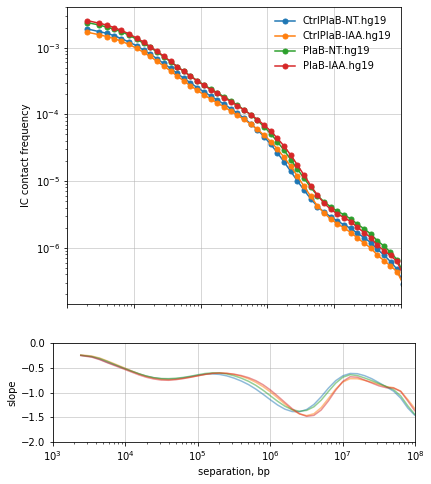

In [100]:
f, axs = plt.subplots(
    figsize=(6.5,8),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)

plot_sample = ['CtrlPlaB-NT.hg19',
             'CtrlPlaB-IAA.hg19',
             'PlaB-NT.hg19',
             'PlaB-IAA.hg19']

plot_exp_type = "B"


ax = axs[0]
for sname in plot_sample:
    for exp_type, ps in plotting_dict[sname]["lb_cvd_agg"].items():
        if exp_type == plot_exp_type:
            ax.loglog(
                ps['s_bp'],
                ps['balanced.avg'],
                'o-',
                markersize=5,
                label=sname,
            )
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)
ax.legend(frameon=False)

ax = axs[1]
for sname in plot_sample:
    for exp_type, slope in plotting_dict[sname]["lb_slopes_agg"].items():
        if exp_type == plot_exp_type:
            ax.semilogx(
                slope['s_bp'],
                slope['slope'],
                alpha=0.5,
                label=sname,
            )
ax.set(
    xlabel='separation, bp', 
    ylabel='slope',
    ylim=(-2,0)
)
ax.grid(lw=0.5)
# ax.legend(frameon=False)

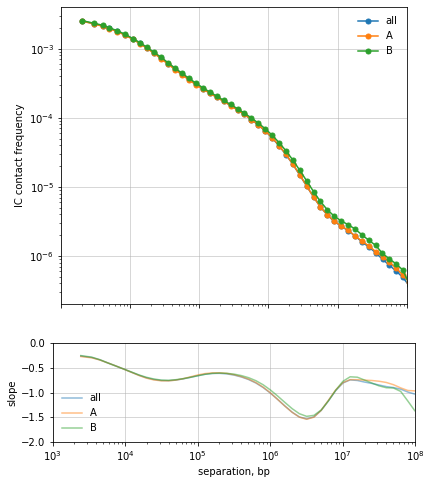

In [105]:
f, axs = plt.subplots(
    figsize=(6.5,8),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)

# ['CtrlPlaB-NT.hg19',
#  'CtrlPlaB-IAA.hg19',
#  'PlaB-NT.hg19',
#  'PlaB-IAA.hg19']

sname = 'PlaB-IAA.hg19'
ax = axs[0]
for exp_type, ps in plotting_dict[sname]["lb_cvd_agg"].items():
    ax.loglog(
        ps['s_bp'],
        ps['balanced.avg'],
        'o-',
        markersize=5,
        label=exp_type,
    )
ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)
ax.legend(frameon=False)

ax = axs[1]
for exp_type, slope in plotting_dict[sname]["lb_slopes_agg"].items():
    ax.semilogx(
        slope['s_bp'],
        slope['slope'],
        alpha=0.5,
        label=exp_type,
    )
ax.set(
    xlabel='separation, bp', 
    ylabel='slope',
    ylim=(-2,0)
)
ax.grid(lw=0.5)
ax.legend(frameon=False)

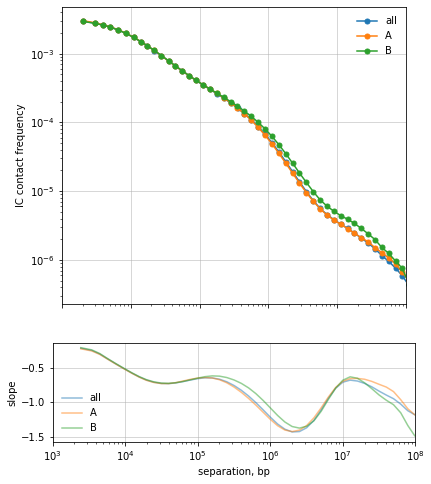

In [111]:
f, axs = plt.subplots(
    figsize=(6.5,8),
    nrows=2, 
    gridspec_kw={'height_ratios':[6,2]}, 
    sharex=True)
ax = axs[0]
for exp_type, ps in lb_cvd_agg.items():
    ax.loglog(
        ps['s_bp'],
        ps['balanced.avg'],
        'o-',
        markersize=5,
        label=exp_type,
    )

ax.set(
    ylabel='IC contact frequency',
    xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)
ax.legend(frameon=False)

ax = axs[1]
for exp_type, slope in lb_slopes_agg.items():
    ax.semilogx(
        slope['s_bp'],
        slope['slope'],
        alpha=0.5,
        label=exp_type,
    )
ax.set(
    xlabel='separation, bp', 
    ylabel='slope')
ax.grid(lw=0.5)
ax.legend(frameon=False)

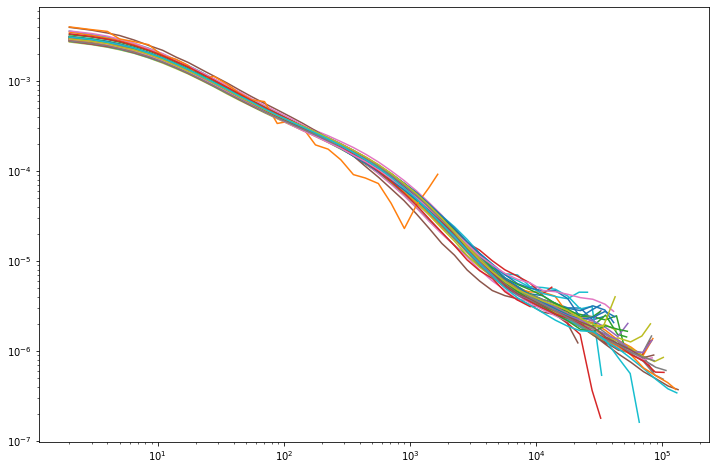

In [81]:
fig = plt.figure(figsize=(12,8))
for reg,_df in lexp_ps.groupby("region"):
    plt.loglog(_df["diag.avg"],_df["balanced.avg"],label=reg)
# plt.legend()

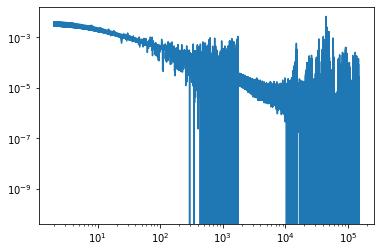

In [56]:
#plt.loglog(exp_df["diag"],exp_df["balanced.avg"])